# Setup Imports

In [25]:
# Setup Essentials
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Models
import torch.nn as nn
import torch.nn.functional as F

# Optimization Functions
import torch.optim as optim

# Superpixel Algorithm
from skimage.segmentation import slic

In [26]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Define data transformations for data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    # transforms.RandomRotation(10),      # Randomly rotate the image by a maximum of 10 degrees
    # transforms.RandomCrop(32, padding=2),  # Randomly crop the image with padding of 2 pixels
    transforms.ToTensor(),              # Convert PIL Image to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize image pixel values
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 5

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Visualize Data

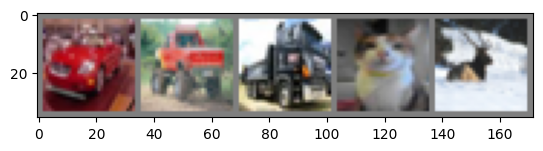

car   truck truck cat   deer 


In [27]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Define Model

In [28]:
poolSize = 2
poolStride = 2

conv1KSize = 3
conv1Pad = 1
conv1Stride = 1    

conv1FMSize = (32 - conv1KSize + (2*conv1Pad)) / conv1Stride + 1
conv1AfterPool = (conv1FMSize - poolSize) / poolStride + 1
if not (conv1FMSize).is_integer() or not (conv1AfterPool).is_integer():
    print("WARNING: VALUES SELECTED FOR CONV1 LAYER ARE INVALID")
conv1FMSize = int(conv1FMSize)
conv1AfterPool = int(conv1AfterPool)

conv2KSize = 3
conv2Pad = 1
conv2Stride = 1

conv2FMSize = (conv1AfterPool - conv2KSize + (2*conv2Pad)) / conv2Stride + 1 
conv2AfterPool = (conv2FMSize - poolSize) / poolStride + 1
if not (conv2FMSize).is_integer() or not (conv2AfterPool).is_integer():
    print("WARNING: VALUES SELECTED FOR CONV2 LAYER ARE INVALID")
conv2FMSize = int(conv2FMSize)
conv2AfterPool = int(conv2AfterPool)

conv3KSize = 3
conv3Pad = 1
conv3Stride = 1

conv3FMSize = (conv2AfterPool - conv3KSize + (2*conv3Pad)) / conv3Stride + 1 
conv3AfterPool = (conv3FMSize - poolSize) / poolStride + 1
if not (conv3FMSize).is_integer() or not (conv3AfterPool).is_integer():
    print("WARNING: VALUES SELECTED FOR CONV3 LAYER ARE INVALID")
conv3FMSize = int(conv3FMSize)
conv3AfterPool = int(conv3AfterPool)

print(f"conv1FMSize={conv1FMSize}, conv1AfterPool={conv1AfterPool}")
print(f"conv2FMSize={conv2FMSize}, conv2AfterPool={conv2AfterPool}")
print(f"conv3FMSize={conv3FMSize}, conv3AfterPool={conv3AfterPool}")

conv1FMSize=32, conv1AfterPool=16
conv2FMSize=16, conv2AfterPool=8
conv3FMSize=8, conv3AfterPool=4


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Convolutional layer 1
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization after conv1
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)  # Convolutional layer 2
        self.bn2 = nn.BatchNorm2d(32)  # Batch normalization after conv2
        self.pool1 = nn.MaxPool2d(2, 2)  # Max pooling layer 1
        self.drop1 = nn.Dropout2d(0.2)  # Dropout layer 1
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Convolutional layer 3
        self.bn3 = nn.BatchNorm2d(64)  # Batch normalization after conv3
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)  # Convolutional layer 4
        self.bn4 = nn.BatchNorm2d(64)  # Batch normalization after conv4
        self.pool2 = nn.MaxPool2d(2, 2)  # Max pooling layer 2
        self.drop2 = nn.Dropout2d(0.3)  # Dropout layer 2
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Convolutional layer 5
        self.bn5 = nn.BatchNorm2d(128)  # Batch normalization after conv5
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)  # Convolutional layer 6
        self.bn6 = nn.BatchNorm2d(128)  # Batch normalization after conv6
        self.pool3 = nn.MaxPool2d(2, 2)  # Max pooling layer 3
        self.drop3 = nn.Dropout2d(0.4)  # Dropout layer 3
        self.fc1 = nn.Linear(128 * 4 * 4, 128)  # Fully connected layer 1
        self.bn7 = nn.BatchNorm1d(128)  # Batch normalization after fc1
        self.drop4 = nn.Dropout(0.5)  # Dropout layer 4
        self.fc2 = nn.Linear(128, 10)  # Fully connected layer 2

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))  # First convolutional layer with ReLU activation and batch norm
        x = F.relu(self.bn2(self.conv2(x)))  # Second convolutional layer with ReLU activation and batch norm
        x = self.drop1(self.pool1(x))  # Max pooling and dropout
        x = F.relu(self.bn3(self.conv3(x)))  # Third convolutional layer with ReLU activation and batch norm
        x = F.relu(self.bn4(self.conv4(x)))  # Fourth convolutional layer with ReLU activation and batch norm
        x = self.drop2(self.pool2(x))  # Max pooling and dropout
        x = F.relu(self.bn5(self.conv5(x)))  # Fifth convolutional layer with ReLU activation and batch norm
        x = F.relu(self.bn6(self.conv6(x)))  # Sixth convolutional layer with ReLU activation and batch norm
        x = self.drop3(self.pool3(x))  # Max pooling and dropout
        x = x.view(-1, 128 * 4 * 4)  # Flatten
        x = F.relu(self.bn7(self.fc1(x)))  # Fully connected layer 1 with ReLU activation and batch norm
        x = self.drop4(x)  # Dropout
        x = self.fc2(x)  # Fully connected layer 2
        return x


# # Make use of GPU if possible
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"device=\"{device}\"")
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

device="cuda"


# Train Model

In [30]:
losses = []
for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # if i % 2000 == 1999:    # print every 2000 mini-batches
            # print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10000:.3f}')
            # running_loss = 0.0

    print(f'epoch={epoch + 1} loss: {running_loss / 10_000:.3f}')
    losses.append(running_loss/10_000)

    if epoch > 9:
        if losses[epoch-10] - (running_loss / 10_000) < 0.01:
            break


print('Finished Training')

epoch=1 loss: 1.844
epoch=2 loss: 1.587
epoch=3 loss: 1.432
epoch=4 loss: 1.344
epoch=5 loss: 1.281
epoch=6 loss: 1.228
epoch=7 loss: 1.190
epoch=8 loss: 1.144
epoch=9 loss: 1.113
epoch=10 loss: 1.084
epoch=11 loss: 1.060
epoch=12 loss: 1.042
epoch=13 loss: 1.020
epoch=14 loss: 1.001
epoch=15 loss: 0.981
epoch=16 loss: 0.958
epoch=17 loss: 0.952
epoch=18 loss: 0.942
epoch=19 loss: 0.935
epoch=20 loss: 0.912
epoch=21 loss: 0.906
epoch=22 loss: 0.887
epoch=23 loss: 0.884
epoch=24 loss: 0.876
epoch=25 loss: 0.866
epoch=26 loss: 0.856
epoch=27 loss: 0.845
epoch=28 loss: 0.834
epoch=29 loss: 0.840
epoch=30 loss: 0.841
epoch=31 loss: 0.819
epoch=32 loss: 0.820
epoch=33 loss: 0.809
epoch=34 loss: 0.806
epoch=35 loss: 0.798
epoch=36 loss: 0.789
epoch=37 loss: 0.786
epoch=38 loss: 0.795
epoch=39 loss: 0.785
epoch=40 loss: 0.782
epoch=41 loss: 0.773
epoch=42 loss: 0.764
epoch=43 loss: 0.760
epoch=44 loss: 0.763
epoch=45 loss: 0.749
epoch=46 loss: 0.752
epoch=47 loss: 0.749
epoch=48 loss: 0.739
e

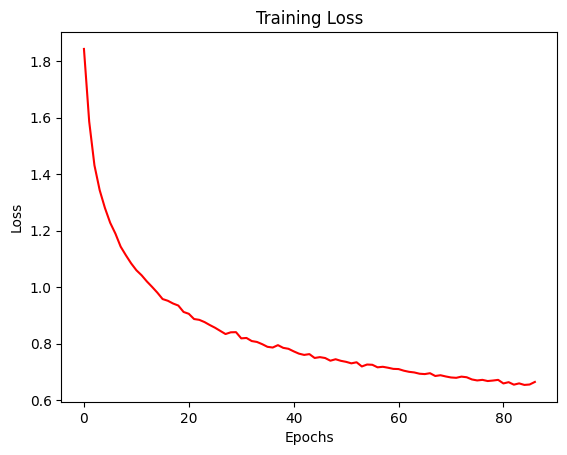

In [31]:
plt.plot(losses, 'r')  # Plotting the loss values with red color ('r')
plt.xlabel('Epochs')  # Labeling the x-axis as 'Epochs'
plt.ylabel('Loss')  # Labeling the y-axis as 'Loss'
plt.title('Training Loss')  # Adding a title to the plot
plt.show()  # Displaying the plot

# Save Model

In [32]:
PATH = 'models/cifar_cnn_cq.pth'
torch.save(net.state_dict(), PATH)

In [33]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
# imshow(torchvision.utils.make_grid(images))
# print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# Check Accuracy

## Overall Accuracy

In [34]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total}%')

Accuracy of the network on the 10000 test images: 75%


## Accuracy Per Class

In [35]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 77.5 %
Accuracy for class: car   is 88.8 %
Accuracy for class: bird  is 64.6 %
Accuracy for class: cat   is 59.6 %
Accuracy for class: deer  is 72.6 %
Accuracy for class: dog   is 66.5 %
Accuracy for class: frog  is 78.4 %
Accuracy for class: horse is 77.4 %
Accuracy for class: ship  is 82.6 %
Accuracy for class: truck is 84.5 %


In [36]:
del dataiter

# Code For Loading Learned Weights

In [37]:
%%script false --no-raise-error # Disables the cell
net = Net()
net.load_state_dict(torch.load(PATH))

Couldn't find program: 'false'
